# Pozivanje Fortran i C koda iz Pythona

In [1]:
%pylab inline
from IPython.display import Image

Populating the interactive namespace from numpy and matplotlib


Prednost Pythona je što je fleksibilan i jednostavan za programiranje. Vrijeme potrebno za postavljanje novog znanstvenog izračuna je stoga kratko. Za određene vrste izračuna Python (i bilo koji drugi interpreter) može biti vrlo spor. Posebno je teško učinkovito izvesti iteracije preko velikih nizova.

Takvi se izračuni mogu implementirati u kompajliranom jeziku kao što je C ili Fortran. U Pythonu je relativno lako pozvati `library` s  C ili Fortran kodom. U ovom predavanju ćemo pogledati kako to učiniti.

 i zašto...

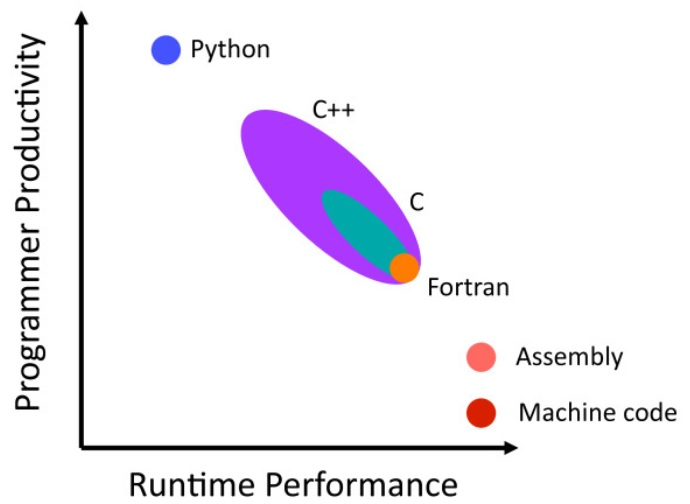

In [2]:
Image(filename='slike/performanse.jpg')

## Fortran

### F2PY

F2PY je program koji (gotovo) automatski wrapa fortran kod za korištenje u Python: Korištenjem `f2py` programa možemo kompajlirati fortran kod u modul koji možemo uvesti u Python program.

F2PY je dio NumPy-ja, ali također ćete morati imati fortran kompajler za pokretanje primjera u nastavku.
Upute su na:
https://anaconda.org/conda-forge/fortran-compiler/

### Primjer  skalarni ulaz, bez izlaznih podataka

In [3]:
%%file hellofortran.f
C File  hellofortran.f
        subroutine hellofortran (n)
        integer n
       
        do 100 i=0, n
            print *, "Fortran says hello"
100     continue
        end

Writing hellofortran.f


Generirajte python modul uz `f2py`:

In [4]:
!f2py -c -m hellofortran hellofortran.f


C:\Users\ZOEEM-LAB1\Desktop\tehnike\predavanja\7_hpc>call "C:\Anaconda3\Scripts\\..\python.exe" "C:\Anaconda3\Scripts\\f2py.py" -c -m hellofortran hellofortran.f 
running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "hellofortran" sources
f2py options: []
f2py:> C:\Users\ZOEEM-~1\AppData\Local\Temp\tmp88gijlf7\src.win-amd64-3.7\hellofortranmodule.c
creating C:\Users\ZOEEM-~1\AppData\Local\Temp\tmp88gijlf7\src.win-amd64-3.7
Reading fortran codes...
	Reading file 'hellofortran.f' (format:fix,strict)
Post-processing...
	Block: hellofortran
			Block: hellofortran
Post-processing (stage 2)...
Building modules...
	Building module "hellofortran"...
		Constructing wrapper function "hellofortran"...
		  hellofortran(n)
	Wrote C/API module "hellofortran" to file "C:\Users\ZOEEM-~1\AppD

Primjer Python skripte koja koristi ovaj modul:

In [5]:
%%file hello.py
import hellofortran

hellofortran.hellofortran(3)

Writing hello.py


In [6]:
# pokreni skriptu
!python hello.py

 Fortran says hello
 Fortran says hello
 Fortran says hello
 Fortran says hello


### Primjer: vektor ulaznih podataka i skalarni izlaz

In [7]:
%%file dprod.f

       subroutine dprod(x, y, n)
    
       double precision x(n), y
       y = 1.0
    
       do 100 i=1, n
           y = y * x(i)
100    continue
       end

Writing dprod.f


In [8]:
!f2py -m dprod -h dprod.pyf dprod.f --overwrite-signature


C:\Users\ZOEEM-LAB1\Desktop\tehnike\predavanja\7_hpc>call "C:\Anaconda3\Scripts\\..\python.exe" "C:\Anaconda3\Scripts\\f2py.py" -m dprod -h dprod.pyf dprod.f --overwrite-signature 
Reading fortran codes...
	Reading file 'dprod.f' (format:fix,strict)
Post-processing...
	Block: dprod
{}
In: :dprod:dprod.f:dprod
vars2fortran: No typespec for argument "n".
			Block: dprod
Post-processing (stage 2)...
Saving signatures to file ".\dprod.pyf"


Modul ne zna koji su argumenti potprograma Fortran ulaz i izlaz, tako da moramo ručno urediti datoteke deklaracije modula i označiti izlazne varijable s `intent(out)` i ulazne varijable s `intent(in)`:

In [9]:
%%file dprod.pyf
python module dprod ! in 
    interface  ! in :dprod
        subroutine dprod(x,y,n) ! in :dprod:dprod.f
            double precision dimension(n), intent(in) :: x
            double precision, intent(out) :: y
            integer, optional,check(len(x)>=n),depend(x),intent(in) :: n=len(x)
        end subroutine dprod
    end interface 
end python module dprod

Overwriting dprod.pyf


Potrebno je kompajlirati kod u modul za Python:

In [10]:
!f2py -c dprod.pyf dprod.f


C:\Users\ZOEEM-LAB1\Desktop\tehnike\predavanja\7_hpc>call "C:\Anaconda3\Scripts\\..\python.exe" "C:\Anaconda3\Scripts\\f2py.py" -c dprod.pyf dprod.f 
running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "dprod" sources
creating C:\Users\ZOEEM-~1\AppData\Local\Temp\tmpbqq_dkd8\src.win-amd64-3.7
f2py options: []
f2py: dprod.pyf
Reading fortran codes...
	Reading file 'dprod.pyf' (format:free)
Post-processing...
	Block: dprod
			Block: dprod
Post-processing (stage 2)...
Building modules...
	Building module "dprod"...
		Constructing wrapper function "dprod"...
		  y = dprod(x,[n])
	Wrote C/API module "dprod" to file "C:\Users\ZOEEM-~1\AppData\Local\Temp\tmpbqq_dkd8\src.win-amd64-3.7\dprodmodule.c"
  adding 'C:\Users\ZOEEM-~1\AppData\Local\Temp\tmpbqq_dkd8\src.win-amd64-3.7\fortran

#### Korištenje modula iz Pythona

In [11]:
import dprod

In [12]:
help(dprod)

Help on module dprod:

NAME
    dprod

DESCRIPTION
    This module 'dprod' is auto-generated with f2py (version:2).
    Functions:
      y = dprod(x,n=len(x))
    .

DATA
    dprod = <fortran object>

VERSION
    b'$Revision: $'

FILE
    c:\users\zoeem-lab1\desktop\tehnike\predavanja\7_hpc\dprod.cp37-win_amd64.pyd




In [13]:
dprod.dprod(arange(1,50))

6.082818640342675e+62

In [14]:
# usporedba s numpyom
prod(arange(1.0,50.0))

6.082818640342675e+62

In [15]:
dprod.dprod(arange(1,10), 5) # 5 prvih elemenata

120.0

Usporedi performanse:

In [16]:
xvec = rand(600)

In [17]:
timeit dprod.dprod(xvec)

1.09 µs ± 18.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [18]:
timeit xvec.prod()

3.52 µs ± 127 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Primjer: kumulativna suma, vektorski ulaz i izlaz

Funkcija kumulativne sume za niz podataka dobar je primjer zahtjevnog računa: Prođite kroz vektor i pohranite kumulativnu sumu u drugi vektor.

In [19]:
# simple python  - sporo
# jer je petlja u Pythonu
def py_dcumsum(a):
    b = empty_like(a)
    b[0] = a[0]
    for n in range(1,len(a)):
        b[n] = b[n-1]+a[n]
    return b

Fortran potprogram za istu stvar: ovdje smo dodali `intent(in)` i `intent(out)` kao retke komentara u izvornom fortranskom kodu, tako da ne moramo ručno uređivati datoteku deklaracije modula fortranskog koda koju generira ` f2py`.

In [20]:
%%file dcumsum.f
c File dcumsum.f
       subroutine dcumsum(a, b, n)
       double precision a(n)
       double precision b(n)
       integer n
cf2py  intent(in) :: a
cf2py  intent(out) :: b
cf2py  intent(hide) :: n

       b(1) = a(1)
       do 100 i=2, n
           b(i) = b(i-1) + a(i)
100    continue
       end

Writing dcumsum.f


Kompajlirajmo kod u modul:

In [21]:
!f2py -c dcumsum.f -m dcumsum


C:\Users\ZOEEM-LAB1\Desktop\tehnike\predavanja\7_hpc>call "C:\Anaconda3\Scripts\\..\python.exe" "C:\Anaconda3\Scripts\\f2py.py" -c dcumsum.f -m dcumsum 
running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "dcumsum" sources
f2py options: []
f2py:> C:\Users\ZOEEM-~1\AppData\Local\Temp\tmp8up1a23u\src.win-amd64-3.7\dcumsummodule.c
creating C:\Users\ZOEEM-~1\AppData\Local\Temp\tmp8up1a23u\src.win-amd64-3.7
Reading fortran codes...
	Reading file 'dcumsum.f' (format:fix,strict)
Post-processing...
	Block: dcumsum
			Block: dcumsum
Post-processing (stage 2)...
Building modules...
	Building module "dcumsum"...
		Constructing wrapper function "dcumsum"...
		  b = dcumsum(a)
	Wrote C/API module "dcumsum" to file "C:\Users\ZOEEM-~1\AppData\Local\Temp\tmp8up1a23u\src.win-amd64-3.7\dcumsu

In [22]:
import dcumsum

In [23]:
a = array([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0])

In [24]:
py_dcumsum(a)

array([ 1.,  3.,  6., 10., 15., 21., 28., 36.])

In [25]:
dcumsum.dcumsum(a)

array([ 1.,  3.,  6., 10., 15., 21., 28., 36.])

In [26]:
cumsum(a)

array([ 1.,  3.,  6., 10., 15., 21., 28., 36.])

Benchmark različitih implementacija:

In [27]:
a = rand(9000)

In [28]:
timeit py_dcumsum(a)

3.79 ms ± 77.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
timeit dcumsum.dcumsum(a)

15.3 µs ± 227 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [30]:
timeit a.cumsum()

32.8 µs ± 918 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Dodatno

1. https://numpy.org/doc/stable/f2py/


## C

## Cython

Hibrid između Pythona i C-a koji se može prevesti: U osnovi Python kod s deklaracijama tipa.

### Cython u notebooku

Koristeći `%%cython`  možemo unijeti Cython kod u ćeliju i ostaviti neka se IPython pobrine za konverziju u C kod, kompajliranje i učitavanje funkcije. Za to nam treba cython. 

Ako nije instaliran:
https://anaconda.org/anaconda/cython

In [31]:
%load_ext cython

In [32]:
a = rand(100000)

In [33]:
b = empty_like(a)

In [34]:
%%cython -a

cimport numpy

def cy_dcumsum2(numpy.ndarray[numpy.float64_t, ndim=1] a, numpy.ndarray[numpy.float64_t, ndim=1] b):
    cdef int i, n = len(a)
    b[0] = a[0]
    for i from 1 <= i < n:
        b[i] = b[i-1] + a[i]
    return b

In [35]:
timeit cy_dcumsum2(a,b)

340 µs ± 5.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Iskoristimo cython za izračun prema : https://en.wikipedia.org/wiki/Mandelbrot_set

In [36]:
import numpy as np

size = 400
iterations = 100


In [37]:
%%cython -a
import numpy as np

def mandelbrot_cython(m, size, iterations):
    for i in range(size):
        for j in range(size):
            c = -2 + 3./size*j + 1j*(1.5-3./size*i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

In [38]:
s = (size, size)


In [39]:
%%timeit -n1 -r1 m = np.zeros(s, dtype=np.int32) 
mandelbrot_cython(m, size, iterations)

7.07 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [40]:
%%cython -a
import numpy as np

def mandelbrot_cython(int[:,::1] m,
                      int size,
                      int iterations):
    cdef int i, j, n
    cdef complex z, c
    for i in range(size):
        for j in range(size):
            c = -2 + 3./size*j + 1j*(1.5-3./size*i)
            z = 0
            for n in range(iterations):
                if z.real**2 + z.imag**2 <= 100:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

In [41]:
%%timeit -n1 -r1 m = np.zeros(s, dtype=np.int32)
mandelbrot_cython(m, size, iterations)

423 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Dodatno

* http://cython.org


Primjer: Odredite raspodjelu potencijala u prostoru prema slici i prikažite ga slikom. Generirajte kod koristeći Python, Fortran i Cython. Usporedite vremena izvođenja. Koristite raster 50x50 i iterativni postupak dok odstupanje koraka ne bude manje od 0,1%.
Uputa: Laplaceova jednadžba koja određuje potencijal u prostoru može se dobro aproksimirati kao srednja vrijednost četiri okolna čvora.

    

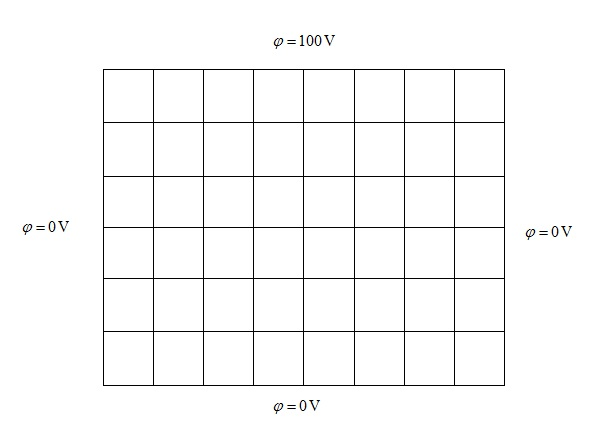

In [61]:
Image(filename='slike/potencijal.jpg')